In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [22]:
import numpy as np
import pandas as pd
import random
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from collections import Counter
from tqdm import tqdm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import recall_score, precision_score, f1_score, matthews_corrcoef, confusion_matrix, accuracy_score
#from imblearn.metrics import geometric_mean_score
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
from torchvision import datasets

# Xception

In [2]:
dataset_path = '/kaggle/input/forarsenicmrg/For_Arsenic_Merge_v2'

In [23]:
dataset = datasets.ImageFolder(root= dataset_path)
class_names = dataset.classes

In [4]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import layers, models

# =========================
# Dataset creation
# =========================
data_dir = dataset_path  # your dataset folder
img_size = (299, 299)    # Xception expects 299x299
batch_size = 32

# 80% train+val
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# 20% test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Split train_val into train and val
train_val_size = train_val_ds.cardinality().numpy()
train_size = int(train_val_size * 0.75)
val_size = train_val_size - train_size

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)

# =========================
# Preprocessing function
# =========================
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_batch(images, labels):
    images = preprocess_input(images)  # Xception preprocessing
    return images, labels

train_ds = train_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)

# Prefetch for performance
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 11986 files belonging to 20 classes.
Using 9589 files for training.
Found 11986 files belonging to 20 classes.
Using 2397 files for validation.


In [6]:
# =========================
# Model creation
# =========================
num_classes = len(train_val_ds.class_names)

base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 10, 10, 2048)   │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,391,164 (81.60 MB)

 Trainable params: 529,684 (2.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights from the epoch with best val_loss
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',        # File path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only when improvement
    verbose=1
)

In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25


I0000 00:00:1755098796.919058      90 service.cc:148] XLA service 0x7cc61401a4b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755098796.920127      90 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755098796.920149      90 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755098798.396164      90 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-08-13 15:26:44.975704: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f32[32,128,147,147]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,147,147]{3,2,1,0}, f32[128,128,1,1]{3,2,1,0}), window={size=1x1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0

225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.2406 - loss: 2.5764
Epoch 1: val_loss improved from inf to 1.81966, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 176s 667ms/step - accuracy: 0.2410 - loss: 2.5751 - val_accuracy: 0.4939 - val_loss: 1.8197
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4994 - loss: 1.7395
Epoch 2: val_loss improved from 1.81966 to 1.49603, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 131s 583ms/step - accuracy: 0.4994 - loss: 1.7393 - val_accuracy: 0.5630 - val_loss: 1.4960
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.5525 - loss: 1.4804
Epoch 3: val_loss improved from 1.49603 to 1.34309, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 132s 586ms/step - accuracy: 0.5525 - loss: 1.4803 - val_accuracy: 0.5986 - val_loss: 1.3431
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6138 - loss: 1.3011
Epoch 4: val_loss improved from 1.34309 to 1.24125, sa

In [11]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=25,  # Start counting from 25
    epochs=35,          # Total final epoch number
    callbacks=[early_stopping, checkpoint]
)

Epoch 26/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8641 - loss: 0.4762
Epoch 26: val_loss improved from 0.76390 to 0.76075, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 134s 598ms/step - accuracy: 0.8641 - loss: 0.4763 - val_accuracy: 0.7648 - val_loss: 0.7607
Epoch 27/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8683 - loss: 0.4637
Epoch 27: val_loss improved from 0.76075 to 0.75467, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 133s 590ms/step - accuracy: 0.8683 - loss: 0.4637 - val_accuracy: 0.7706 - val_loss: 0.7547
Epoch 28/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8724 - loss: 0.4445
Epoch 28: val_loss did not improve from 0.75467
225/225 ━━━━━━━━━━━━━━━━━━━━ 131s 583ms/step - accuracy: 0.8724 - loss: 0.4446 - val_accuracy: 0.7698 - val_loss: 0.7560
Epoch 29/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8801 - loss: 0.4293
Epoch 29: val_loss improved from 0.75467 to 0.74404, saving model t

In [13]:
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=35,  # Start counting from 25
    epochs=45,          # Total final epoch number
    callbacks=[early_stopping, checkpoint]
)

Epoch 36/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9018 - loss: 0.3419
Epoch 36: val_loss did not improve from 0.70993
225/225 ━━━━━━━━━━━━━━━━━━━━ 134s 593ms/step - accuracy: 0.9018 - loss: 0.3420 - val_accuracy: 0.7807 - val_loss: 0.7186
Epoch 37/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9132 - loss: 0.3293
Epoch 37: val_loss did not improve from 0.70993
225/225 ━━━━━━━━━━━━━━━━━━━━ 131s 581ms/step - accuracy: 0.9132 - loss: 0.3294 - val_accuracy: 0.7781 - val_loss: 0.7110
Epoch 38/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9135 - loss: 0.3210
Epoch 38: val_loss did not improve from 0.70993
225/225 ━━━━━━━━━━━━━━━━━━━━ 131s 582ms/step - accuracy: 0.9135 - loss: 0.3211 - val_accuracy: 0.7769 - val_loss: 0.7174
Epoch 39/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9185 - loss: 0.3046
Epoch 39: val_loss improved from 0.70993 to 0.70710, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 132s 585ms/step - accurac

In [14]:
acc = history.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy']

loss = history.history['loss'] + history2.history['loss'] + history3.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss']

epochs = range(1, len(acc) + 1)  # 1 to 35

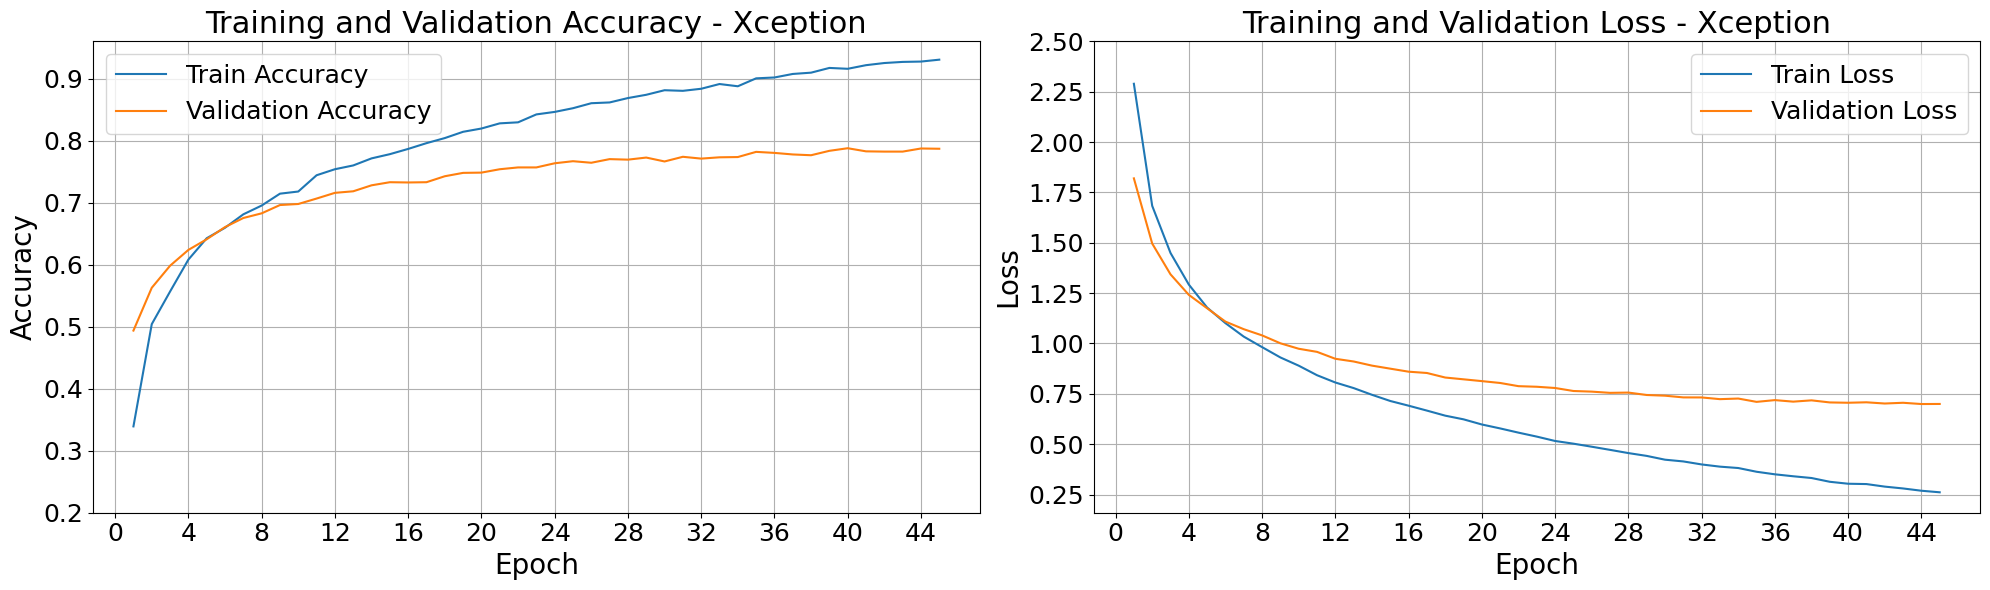

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, len(epochs) + 2, 4)

# Plot accuracy
axs[0].plot(epochs, acc, label='Train Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - Xception', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].set_yticks(np.arange(0.2, 1.0, 0.1))
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(epochs, loss, label='Train Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - Xception', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].set_yticks(np.arange(0.25,2.75,0.25))
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
plt.savefig('Xception_training_curves.png', dpi=600)
plt.savefig('Xception_training_curves.pdf')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

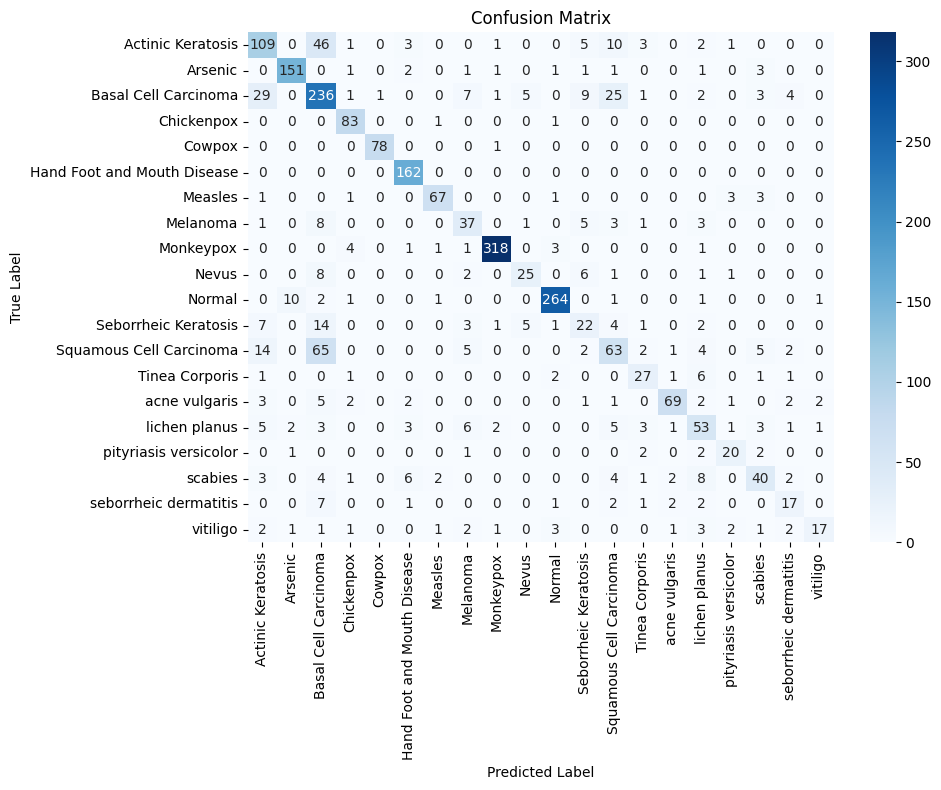

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('Xception_confusion_matrix.png', dpi=600)
plt.savefig('Xception_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('Xception_performance_metrics.csv', index=False)

# ConvNext

In [33]:
# =========================
# Dataset creation
# =========================
data_dir = dataset_path  # your dataset folder
img_size = (224, 224)    # Xception expects 299x299
batch_size = 32

# 80% train+val
train_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# 20% test
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

# Split train_val into train and val
train_val_size = train_val_ds.cardinality().numpy()
train_size = int(train_val_size * 0.75)
val_size = train_val_size - train_size

train_ds = train_val_ds.take(train_size)
val_ds = train_val_ds.skip(train_size)


Found 11986 files belonging to 20 classes.
Using 9589 files for training.
Found 11986 files belonging to 20 classes.
Using 2397 files for validation.


In [34]:
from tensorflow.keras.applications.convnext import ConvNeXtSmall, preprocess_input
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

# =========================
# Dataset (assuming train_ds, val_ds, test_ds already prepared)
# =========================
img_size = (224, 224)  # ConvNeXt expects 224x224

# Preprocessing function
AUTOTUNE = tf.data.AUTOTUNE
def preprocess_batch(images, labels):
    images = preprocess_input(images)  # ConvNeXt preprocessing
    return images, labels

train_ds = train_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(preprocess_batch, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.prefetch(buffer_size=AUTOTUNE)

In [35]:
# =========================
# Model
# =========================
num_classes = len(class_names)

base_model = ConvNeXtSmall(
    weights='imagenet',
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)
base_model.trainable = False  # Freeze base model

# Custom classification head
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
output = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#model.summary()

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor
    patience=5,              # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights from the epoch with best val_loss
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',        # File path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only when improvement
    verbose=1
)

In [37]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25


E0000 00:00:1755107893.333234      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755107893.470510      88 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.1539 - loss: 2.9284

E0000 00:00:1755108024.246782      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755108024.382271      89 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_loss improved from inf to 2.25962, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 162s 586ms/step - accuracy: 0.1542 - loss: 2.9274 - val_accuracy: 0.3700 - val_loss: 2.2596
Epoch 2/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.3555 - loss: 2.2274
Epoch 2: val_loss improved from 2.25962 to 1.89225, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 120s 533ms/step - accuracy: 0.3555 - loss: 2.2271 - val_accuracy: 0.4722 - val_loss: 1.8923
Epoch 3/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.4361 - loss: 1.9299
Epoch 3: val_loss improved from 1.89225 to 1.68412, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 121s 535ms/step - accuracy: 0.4361 - loss: 1.9297 - val_accuracy: 0.5128 - val_loss: 1.6841
Epoch 4/25
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.4877 - loss: 1.7431
Epoch 4: val_loss improved from 1.68412 to 1.54877, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 124s 552ms/step - a

In [38]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=25,  # Start counting from 25
    epochs=35,          # Total final epoch number
    callbacks=[early_stopping, checkpoint]
)

Epoch 26/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7210 - loss: 0.8727
Epoch 26: val_loss improved from 0.89640 to 0.89606, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 118s 524ms/step - accuracy: 0.7210 - loss: 0.8728 - val_accuracy: 0.7225 - val_loss: 0.8961
Epoch 27/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7396 - loss: 0.8400
Epoch 27: val_loss improved from 0.89606 to 0.88309, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 118s 523ms/step - accuracy: 0.7396 - loss: 0.8400 - val_accuracy: 0.7288 - val_loss: 0.8831
Epoch 28/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7387 - loss: 0.8334
Epoch 28: val_loss improved from 0.88309 to 0.87006, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 119s 531ms/step - accuracy: 0.7387 - loss: 0.8335 - val_accuracy: 0.7300 - val_loss: 0.8701
Epoch 29/35
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7314 - loss: 0.8314
Epoch 29: val_loss improved from

In [39]:
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=35,  # Start counting from 25
    epochs=45,          # Total final epoch number
    callbacks=[early_stopping, checkpoint]
)

Epoch 36/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7698 - loss: 0.7408
Epoch 36: val_loss improved from 0.81370 to 0.79941, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 124s 552ms/step - accuracy: 0.7698 - loss: 0.7408 - val_accuracy: 0.7576 - val_loss: 0.7994
Epoch 37/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7738 - loss: 0.7406
Epoch 37: val_loss improved from 0.79941 to 0.79709, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 119s 529ms/step - accuracy: 0.7738 - loss: 0.7407 - val_accuracy: 0.7576 - val_loss: 0.7971
Epoch 38/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7761 - loss: 0.7286
Epoch 38: val_loss improved from 0.79709 to 0.79187, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 118s 523ms/step - accuracy: 0.7761 - loss: 0.7287 - val_accuracy: 0.7589 - val_loss: 0.7919
Epoch 39/45
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7706 - loss: 0.7279
Epoch 39: val_loss did not impro

In [40]:
history4 = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=45,  # Start counting from 25
    epochs=50,          # Total final epoch number
    callbacks=[early_stopping, checkpoint]
)

Epoch 46/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.7938 - loss: 0.6830
Epoch 46: val_loss improved from 0.75359 to 0.74970, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 121s 538ms/step - accuracy: 0.7938 - loss: 0.6830 - val_accuracy: 0.7689 - val_loss: 0.7497
Epoch 47/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7960 - loss: 0.6561
Epoch 47: val_loss improved from 0.74970 to 0.74422, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 123s 546ms/step - accuracy: 0.7960 - loss: 0.6562 - val_accuracy: 0.7706 - val_loss: 0.7442
Epoch 48/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8017 - loss: 0.6531
Epoch 48: val_loss improved from 0.74422 to 0.74020, saving model to best_model.h5
225/225 ━━━━━━━━━━━━━━━━━━━━ 119s 530ms/step - accuracy: 0.8016 - loss: 0.6532 - val_accuracy: 0.7744 - val_loss: 0.7402
Epoch 49/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7992 - loss: 0.6472
Epoch 49: val_loss improved from

In [41]:
acc = history.history['accuracy'] + history2.history['accuracy'] + history3.history['accuracy'] + history4.history['accuracy']
val_acc = history.history['val_accuracy'] + history2.history['val_accuracy'] + history3.history['val_accuracy'] + history4.history['val_accuracy']

loss = history.history['loss'] + history2.history['loss'] + history3.history['loss']+ history4.history['loss']
val_loss = history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss']

epochs = range(1, len(acc) + 1)  # 1 to 35

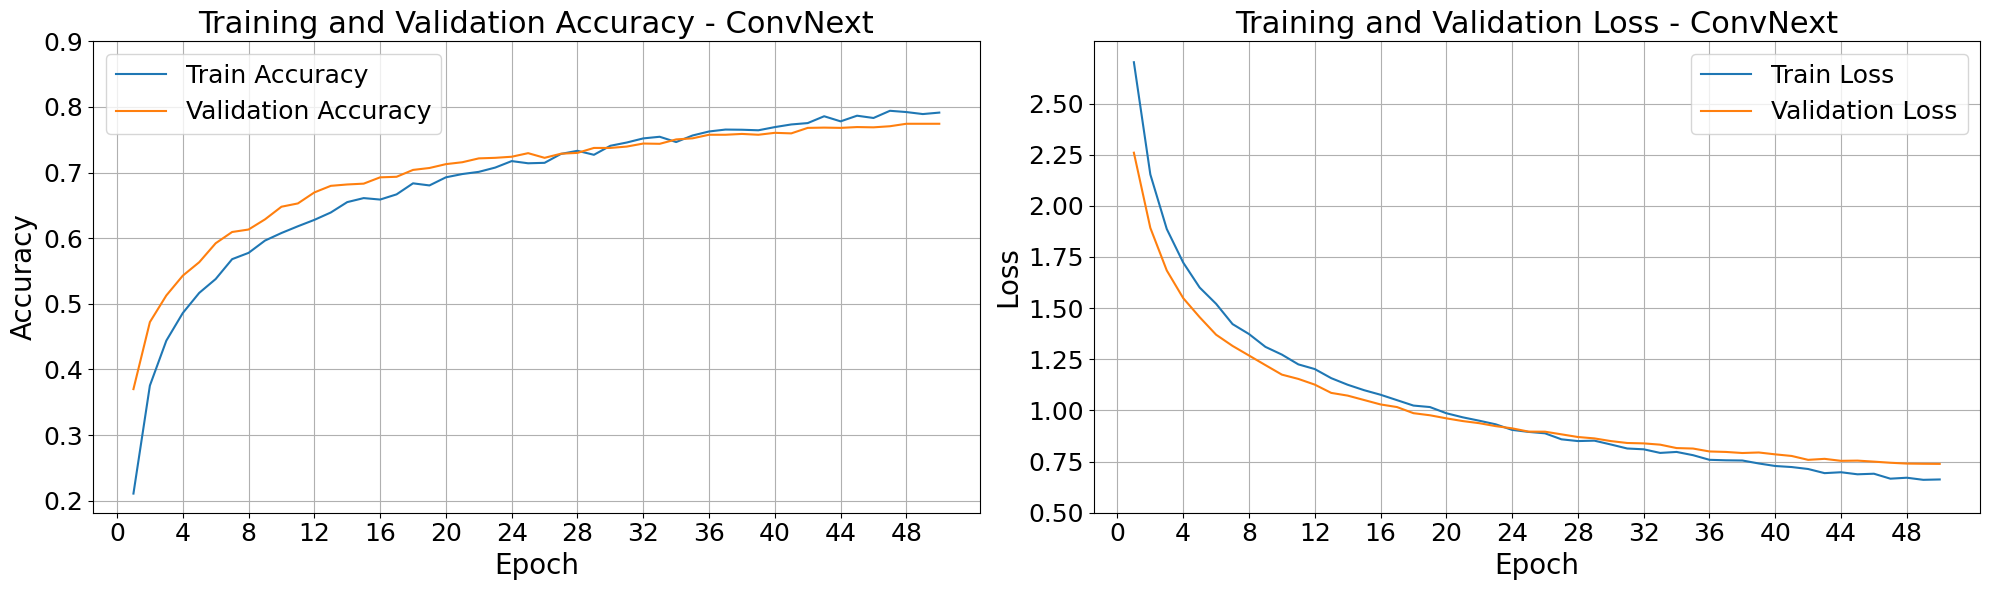

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

num_epochs = len(history.history['accuracy'])  # total epochs trained

# X ticks positions (integers from 0 to num_epochs, step 4)
xticks = range(0, len(epochs) + 2, 4)

# Plot accuracy
axs[0].plot(epochs, acc, label='Train Accuracy')
axs[0].plot(epochs, val_acc, label='Validation Accuracy')
axs[0].set_xlabel('Epoch', fontsize=20)
axs[0].set_ylabel('Accuracy', fontsize=20)
axs[0].set_title('Training and Validation Accuracy - ConvNext', fontsize=22)
axs[0].legend(fontsize=18)
axs[0].set_xticks(xticks)
axs[0].set_yticks(np.arange(0.2, 1.0, 0.1))
axs[0].tick_params(axis='x', labelsize=18)
axs[0].tick_params(axis='y', labelsize=18)
axs[0].grid(True)

# Plot loss
axs[1].plot(epochs, loss, label='Train Loss')
axs[1].plot(epochs, val_loss, label='Validation Loss')
axs[1].set_xlabel('Epoch', fontsize=20)
axs[1].set_ylabel('Loss', fontsize=20)
axs[1].set_title('Training and Validation Loss - ConvNext', fontsize=22)
axs[1].legend(fontsize=18)
axs[1].set_xticks(xticks)
axs[1].set_yticks(np.arange(0.5,2.75,0.25))
axs[1].tick_params(axis='x', labelsize=18)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].grid(True)

plt.tight_layout()

# Save the combined figure
plt.savefig('ConvNext_training_curves.png', dpi=600)
plt.savefig('ConvNext_training_curves.pdf')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

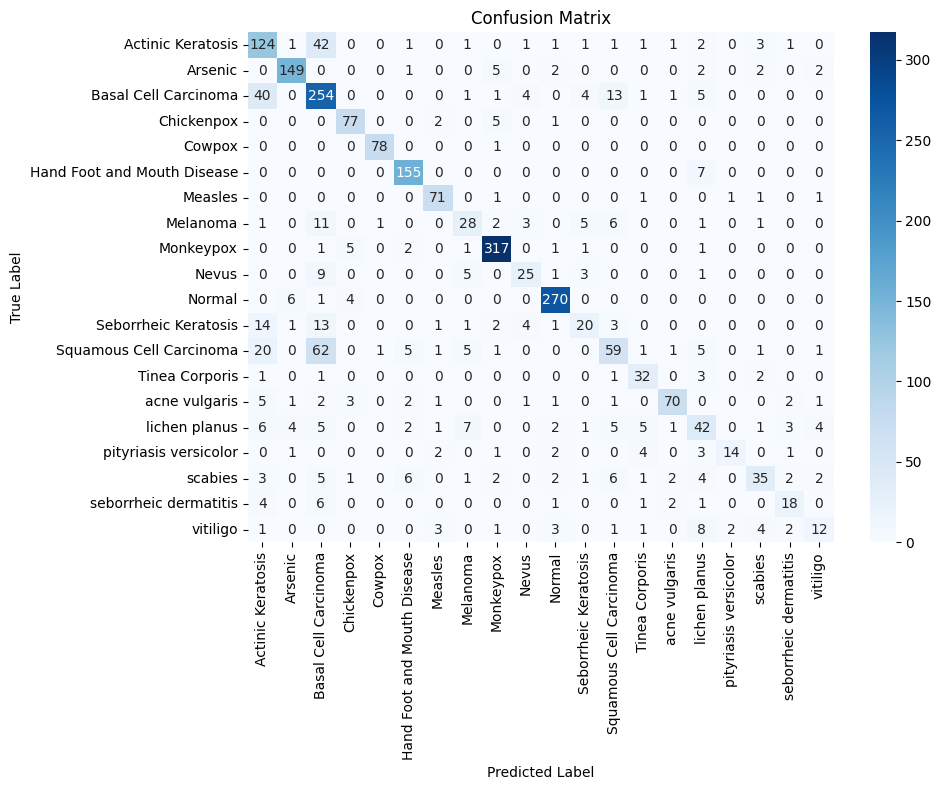

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef

# 1. Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 2. Compute confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
recall = recall_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f'Matthews Correlation Coefficient: {mcc:.4f}')

# 3. Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels= class_names, yticklabels= class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('ConvNext_confusion_matrix.png', dpi=600)
plt.savefig('ConvNext_confusion_matrix.pdf')
plt.show()

# 4. Save metrics to CSV
metrics = {
    'Accuracy': [accuracy],
    'Recall': [recall],
    'Precision': [precision],
    'F1 Score': [f1],
    'MCC':[mcc]
}
df_metrics = pd.DataFrame(metrics)
df_metrics.to_csv('ConvNext_performance_metrics.csv', index=False)